# Plotting HURDAT2 Storms Alongside Drifter Tracks

In this notebook we will walk through how we can use the [`clouddrift`](https://github.com/Cloud-Drift/clouddrift) library to plot NOAA GDP drifter tracks colored by sea surface temperature, alongside storm tracks from the HURDAT2 dataset, with both datasets directly available from the library. HURDAT2 is a dataset that contains storm track data (including pressure, wind speed, etc...) for the time period 1852 to 2022, both from the North Pacific and North Atlantic ocean basins. The HURDAT2 dataset is originally available from [NOAA AOML](https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html), and such is the [NOAA GDP dataset](https://www.aoml.noaa.gov/phod/gdp/index.php).

This notebook proceeds in steps by:

 0. Access and open the necessary datasets
 1. Subset these datasets by selecting their data for a given year and region
 2. Create the base plot where we will plot and update the storm and drifter trajectories
 3. Generate an animation showing as a function of time the selected data.

### 0. Dataset imports

We access and open as an xarray dataset a ragged array version of the [six-hourly NOAA Global Drifter Program dataset](https://www.aoml.noaa.gov/phod/gdp/interpolated/data/all.php) which is hosted as an experiment in an AWS S3 bucket. Please consult the webpage of the dataset to investigate alternative ways of accessing these data. Below we also provide a couple of alternative ways of accessing these data. 

In [1]:
# dataset URL on the AWS S3 bucket:
import xarray as xr

url = "https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/experimental/gdp6h_ragged_sep23.zarr"
drifter_ds = xr.open_dataset(url, decode_times=True, engine="zarr")

# alternatively, access the ragged array 6-hourly dataset from the AOML website via the clouddrift API with the following command:
# drifter_ds = cd.datasets.gdp6h()

# alternatively, access the individual netcdf files from the AOML FTP server and aggegrate locally these data into a ragged array dataset via the cloudrift API with the following command:
# drifter_ds = cd.adapters.gdp6h.to_raggedarray().to_xarray()

drifter_ds

<xarray.Dataset> Size: 2GB
Dimensions:                (traj: 27647, obs: 46535470)
Coordinates:
    id                     (traj) int64 221kB ...
    time                   (obs) datetime64[ns] 372MB ...
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    BuoyTypeManufacturer   (traj) |S20 553kB ...
    BuoyTypeSensorArray    (traj) |S20 553kB ...
    CurrentProgram         (traj) float64 221kB ...
    DeployingCountry       (traj) |S20 553kB ...
    DeployingShip          (traj) |S20 553kB ...
    DeploymentComments     (traj) |S20 553kB ...
    ...                     ...
    start_lon              (traj) float32 111kB ...
    temp                   (obs) float32 186MB ...
    typebuoy               (traj) |S10 276kB ...
    typedeath              (traj) int8 28kB ...
    ve                     (obs) float32 186MB ...
    vn                     (obs) float32 186MB ...
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-04-04T13:44:01.176967
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2023-10-18:18:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

Next we access the HURDAT2 dataset directly using the clouddrift API. The command below looks for the dataset locally and if it is not found the original data are downloaded and aggregated into a ragged array dataset which is then opened as an xarray dataset.

In [2]:
from clouddrift.datasets import hurdat2

storm_ds = hurdat2(decode_times=True)
storm_ds

<xarray.Dataset> Size: 13MB
Dimensions:                          (traj: 3143, obs: 84188)
Coordinates:
    id                               (traj) <U8 101kB ...
    time                             (obs) datetime64[ns] 674kB ...
Dimensions without coordinates: traj, obs
Data variables: (12/22)
    basin                            (traj) <U2 25kB ...
    year                             (traj) int64 25kB ...
    rowsize                          (traj) int64 25kB ...
    record_identifier                (obs) <U1 337kB ...
    system_status                    (obs) <U2 674kB ...
    lat                              (obs) float64 674kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 674kB ...
    max_high_wind_radius_ne          (obs) float64 674kB ...
    max_high_wind_radius_se          (obs) float64 674kB ...
    max_high_wind_radius_sw          (obs) float64 674kB ...
    max_high_wind_radius_nw          (obs) float64 674kB ...
    max_sustained_wind_speed_radius  (obs) float64 674kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-04-03T00:50:15.310668
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

### 1. Subsample the datasets

Next we select specific subsets of the opened datasets. For this, we use the clouddrift `subset` function provided through the `ragged` module which contains helpful utility functions for working with ragged array data structures. Here we choose to subset storms whose track lied within the Atlantic Ocean near the east coast of North America and was observed between August and October of 2020 (feel free to change any of this selection when running this notebook).  The `subset` function requires to define a criteria as a dictionary as follows:

In [3]:
import numpy as np
from datetime import datetime

# define a time range
year = 2017
start_dt, end_dt = (
    np.datetime64(int(datetime(year, 8, 1).timestamp()), "s"), 
    np.datetime64(int(datetime(year, 11, 1).timestamp()), "s")
)
# define the criteria for the drifter and storm datasets; please note that the times are encoding differently in the two datasets and as such we need to specify the time range differently for each criteria.

criteria = dict(
    lat=(10, 60),
    lon=(-90, -20), 
    time=(start_dt, end_dt)
)

We can now use the `subset` function and apply the criteria to both datasets. The `subset` function requires to provide the name of the *row* dimension for the ragged array datasets (see the [clouddrift documentation](https://clouddrift.org)), which is `traj` in both cases.

In [4]:
from clouddrift.ragged import subset

matching_storms = subset(storm_ds, criteria, row_dim_name="traj")
matching_storms

<xarray.Dataset> Size: 69kB
Dimensions:                          (traj: 12, obs: 440)
Coordinates:
    id                               (traj) <U8 384B 'AL062017' ... 'EP202017'
    time                             (obs) datetime64[ns] 4kB 2017-08-01T06:0...
Dimensions without coordinates: traj, obs
Data variables: (12/22)
    basin                            (traj) <U2 96B ...
    year                             (traj) int64 96B ...
    rowsize                          (traj) int64 96B 4 10 28 36 ... 32 35 7 9
    record_identifier                (obs) <U1 2kB ...
    system_status                    (obs) <U2 4kB ...
    lat                              (obs) float64 4kB 27.8 28.7 ... 13.4 13.5
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 4kB ...
    max_high_wind_radius_ne          (obs) float64 4kB ...
    max_high_wind_radius_se          (obs) float64 4kB ...
    max_high_wind_radius_sw          (obs) float64 4kB ...
    max_high_wind_radius_nw          (obs) float64 4kB ...
    max_sustained_wind_speed_radius  (obs) float64 4kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-04-03T00:50:15.310668
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [5]:
matching_drifters = subset(drifter_ds, criteria, row_dim_name="traj")
matching_drifters

<xarray.Dataset> Size: 3MB
Dimensions:                (traj: 239, obs: 67230)
Coordinates:
    id                     (traj) int64 2kB 300234011795230 ... 300234063266890
    time                   (obs) datetime64[ns] 538kB 2017-08-01T06:00:00 ......
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    BuoyTypeManufacturer   (traj) |S20 5kB ...
    BuoyTypeSensorArray    (traj) |S20 5kB ...
    CurrentProgram         (traj) float64 2kB ...
    DeployingCountry       (traj) |S20 5kB ...
    DeployingShip          (traj) |S20 5kB ...
    DeploymentComments     (traj) |S20 5kB ...
    ...                     ...
    start_lon              (traj) float32 956B ...
    temp                   (obs) float32 269kB ...
    typebuoy               (traj) |S10 2kB ...
    typedeath              (traj) int8 239B ...
    ve                     (obs) float32 269kB ...
    vn                     (obs) float32 269kB ...
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2024-04-04T13:44:01.176967
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2023-10-18:18:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

### 2. Setup the Plot.

Subsetting the datasets above, you should have found roughly 10-20 storms and 200-300 drifters. We will now proceed to create a map and an animation to visualize the selected data.

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# create a blank figure with the desired size and resolution
DPI = 384
fig = plt.figure(figsize=(7.75, 4.75), dpi=DPI)

<Figure size 2976x1824 with 0 Axes>

Lets have a look at the selected storms and see what they look like. You can modify the criteria above and rerun the cell below to get an idea of the storm trajectories that matched our query.

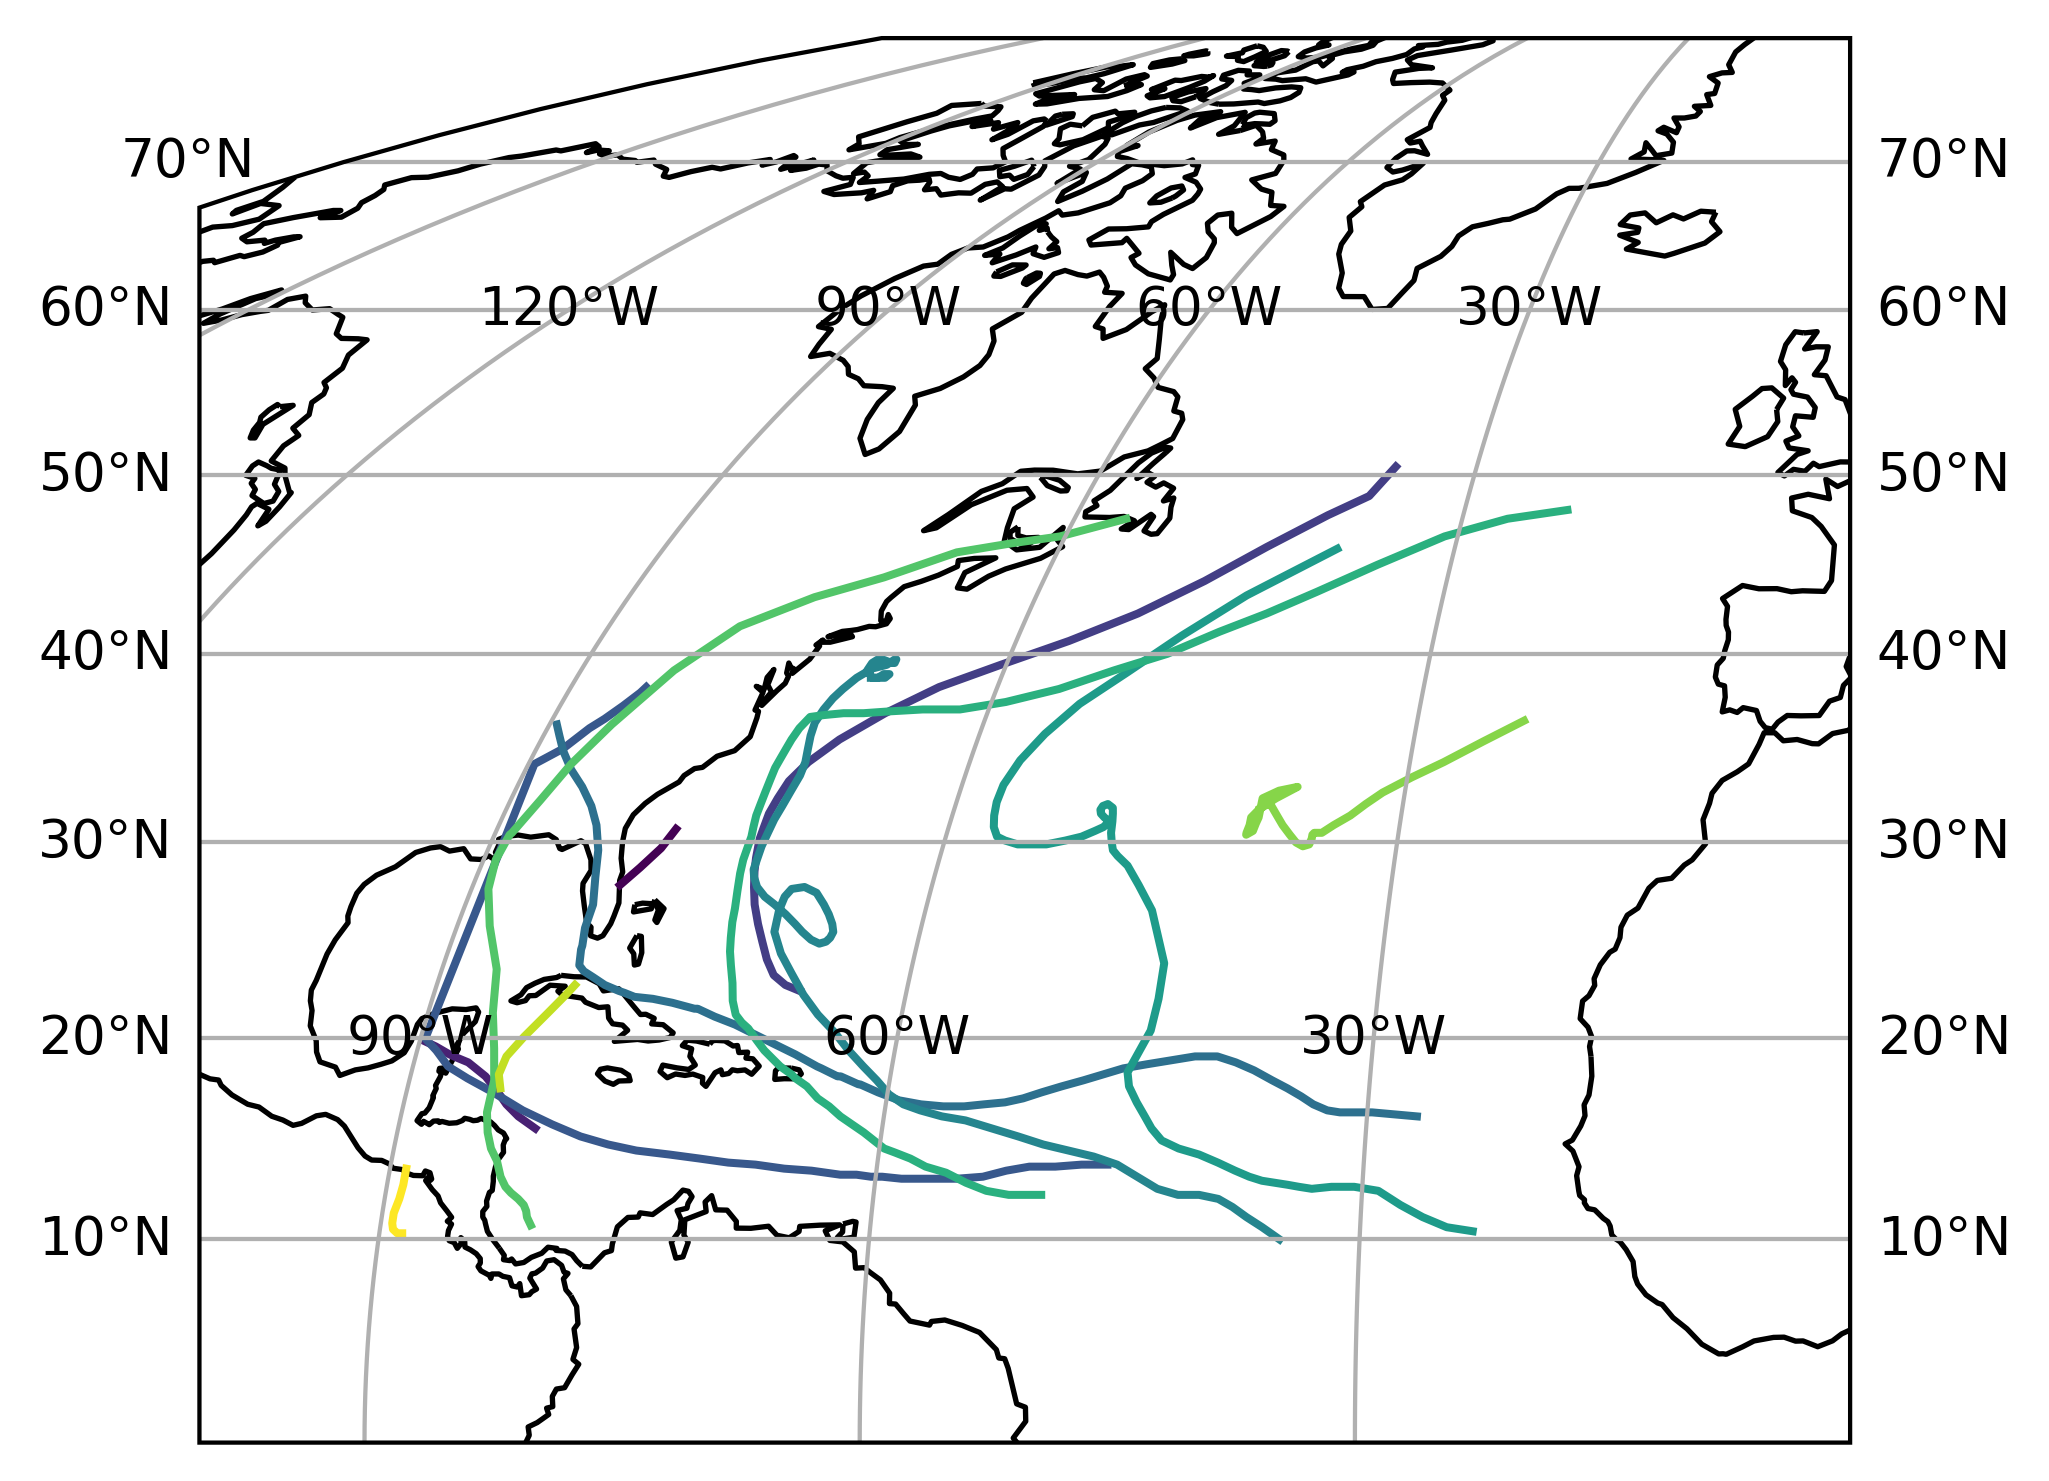

In [7]:
from clouddrift.plotting import plot_ragged

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
l = plot_ragged(
    ax,
    matching_storms.lon,
    matching_storms.lat,
    matching_storms.rowsize,
    transform=ccrs.PlateCarree(),
)

ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80], crs=ccrs.PlateCarree())
fig

We can also take a look into the drifters we've selected. As above, you can modify the criteria above and rerun the cell below to get an idea of the drifter trajectories that matched our query.

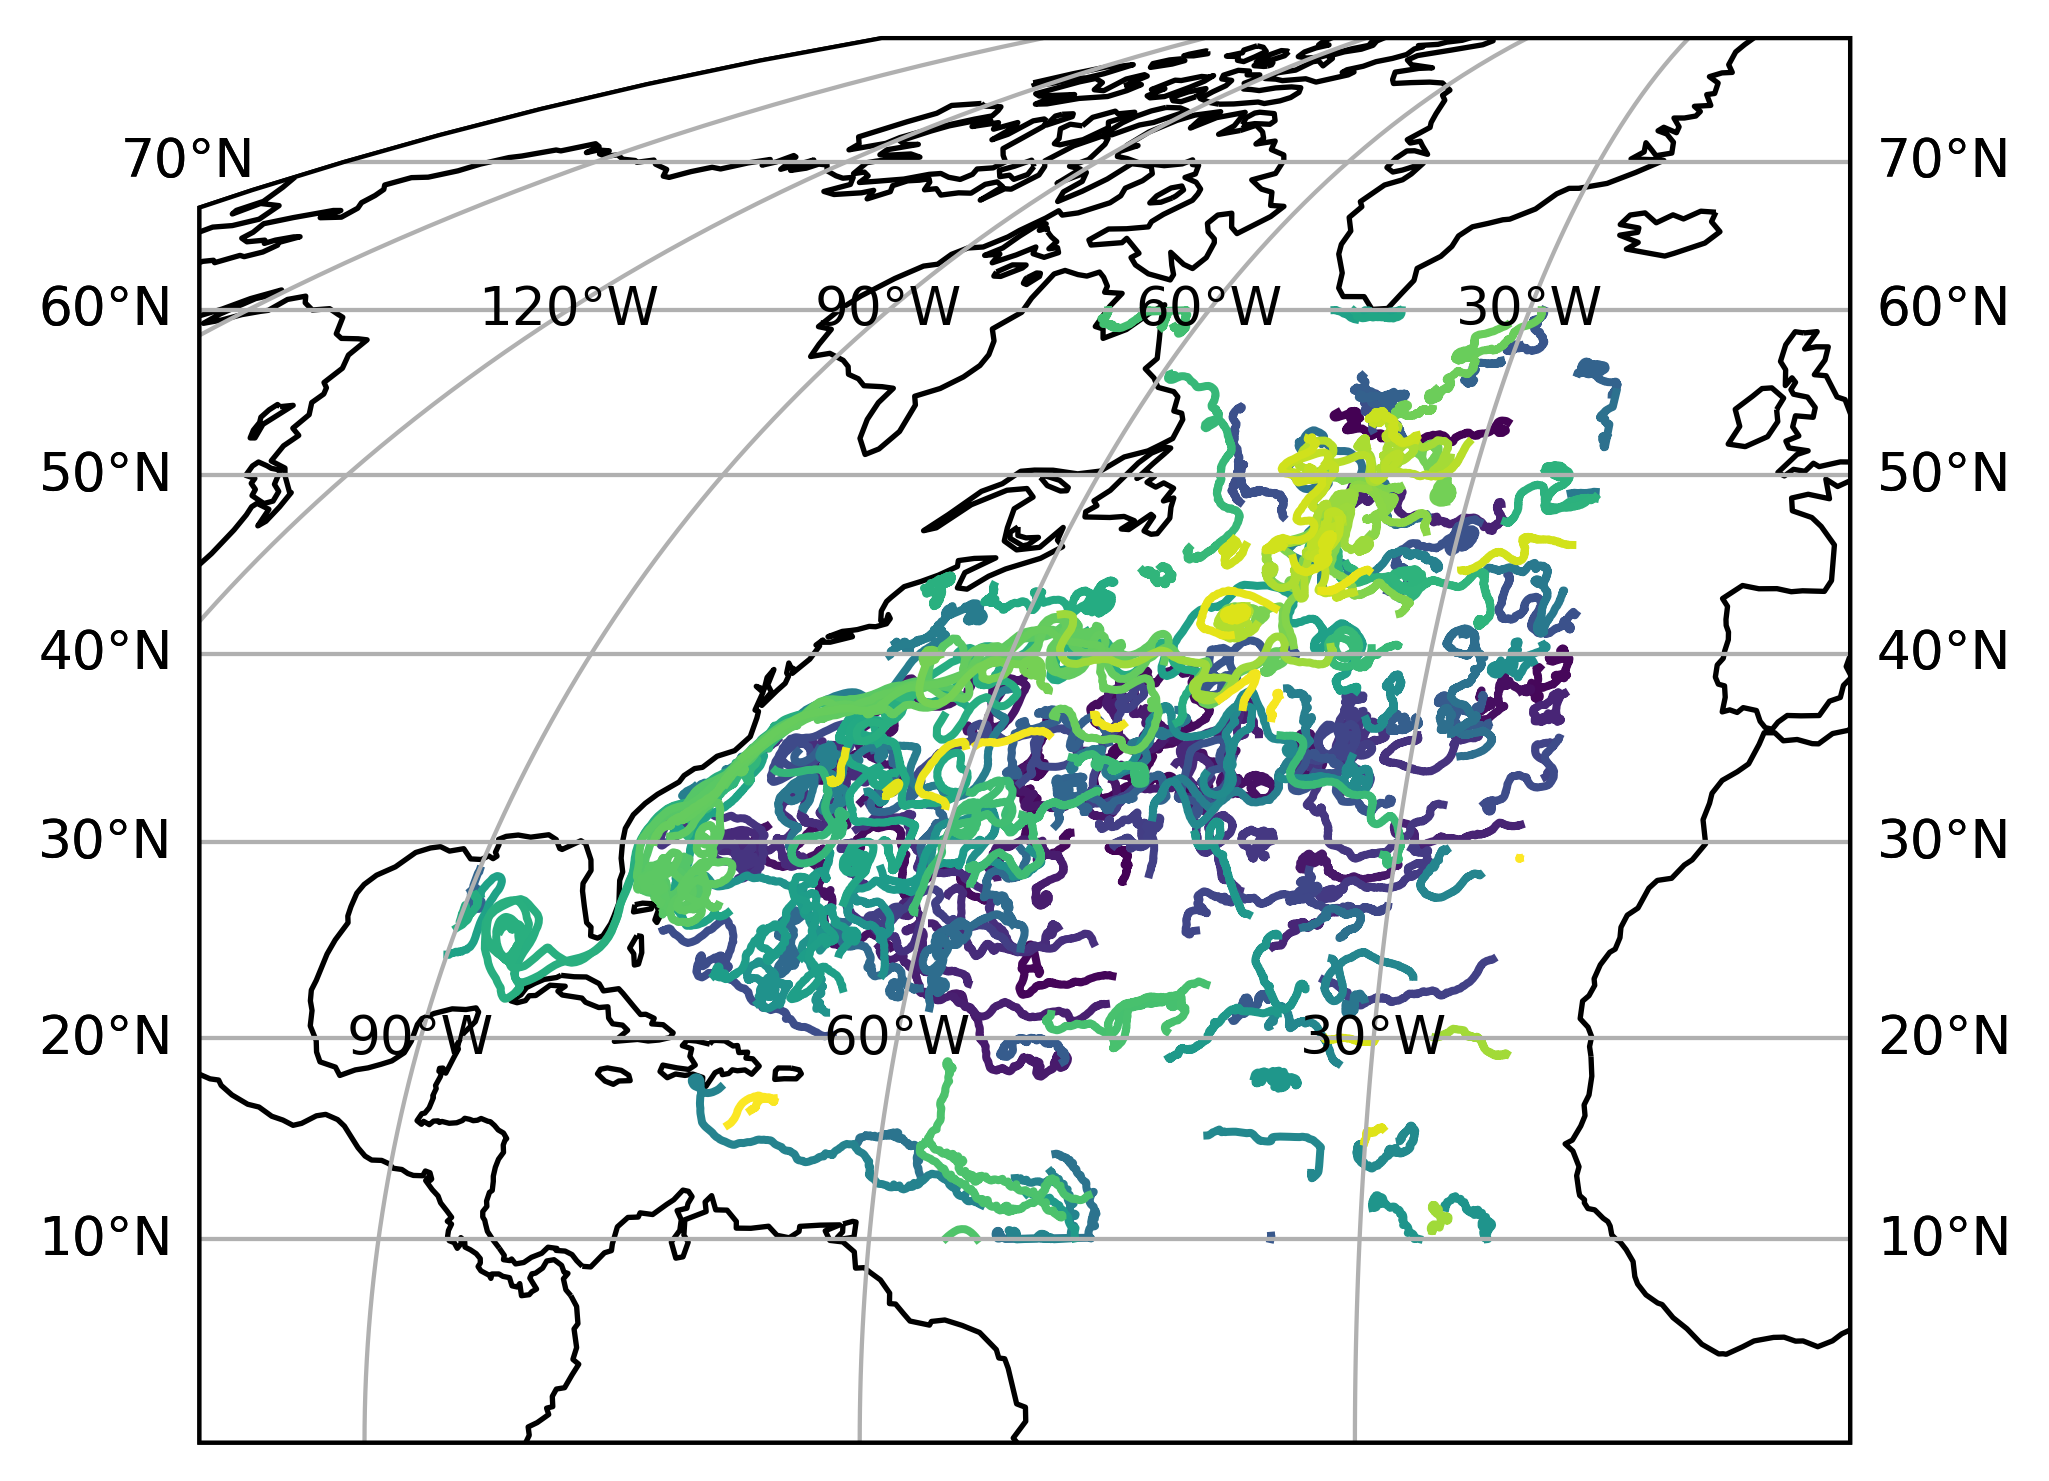

In [8]:
from clouddrift.plotting import plot_ragged

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
l = plot_ragged(
    ax,
    matching_drifters.lon,
    matching_drifters.lat,
    matching_drifters.rowsize,
    transform=ccrs.PlateCarree(),
)

ax.set_extent([-100, 0, 0, 80], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()
fig

Lets now setup the plot were going to use for the animation.

Text(0.5, 1.0, 'Hurricane Season 2017')

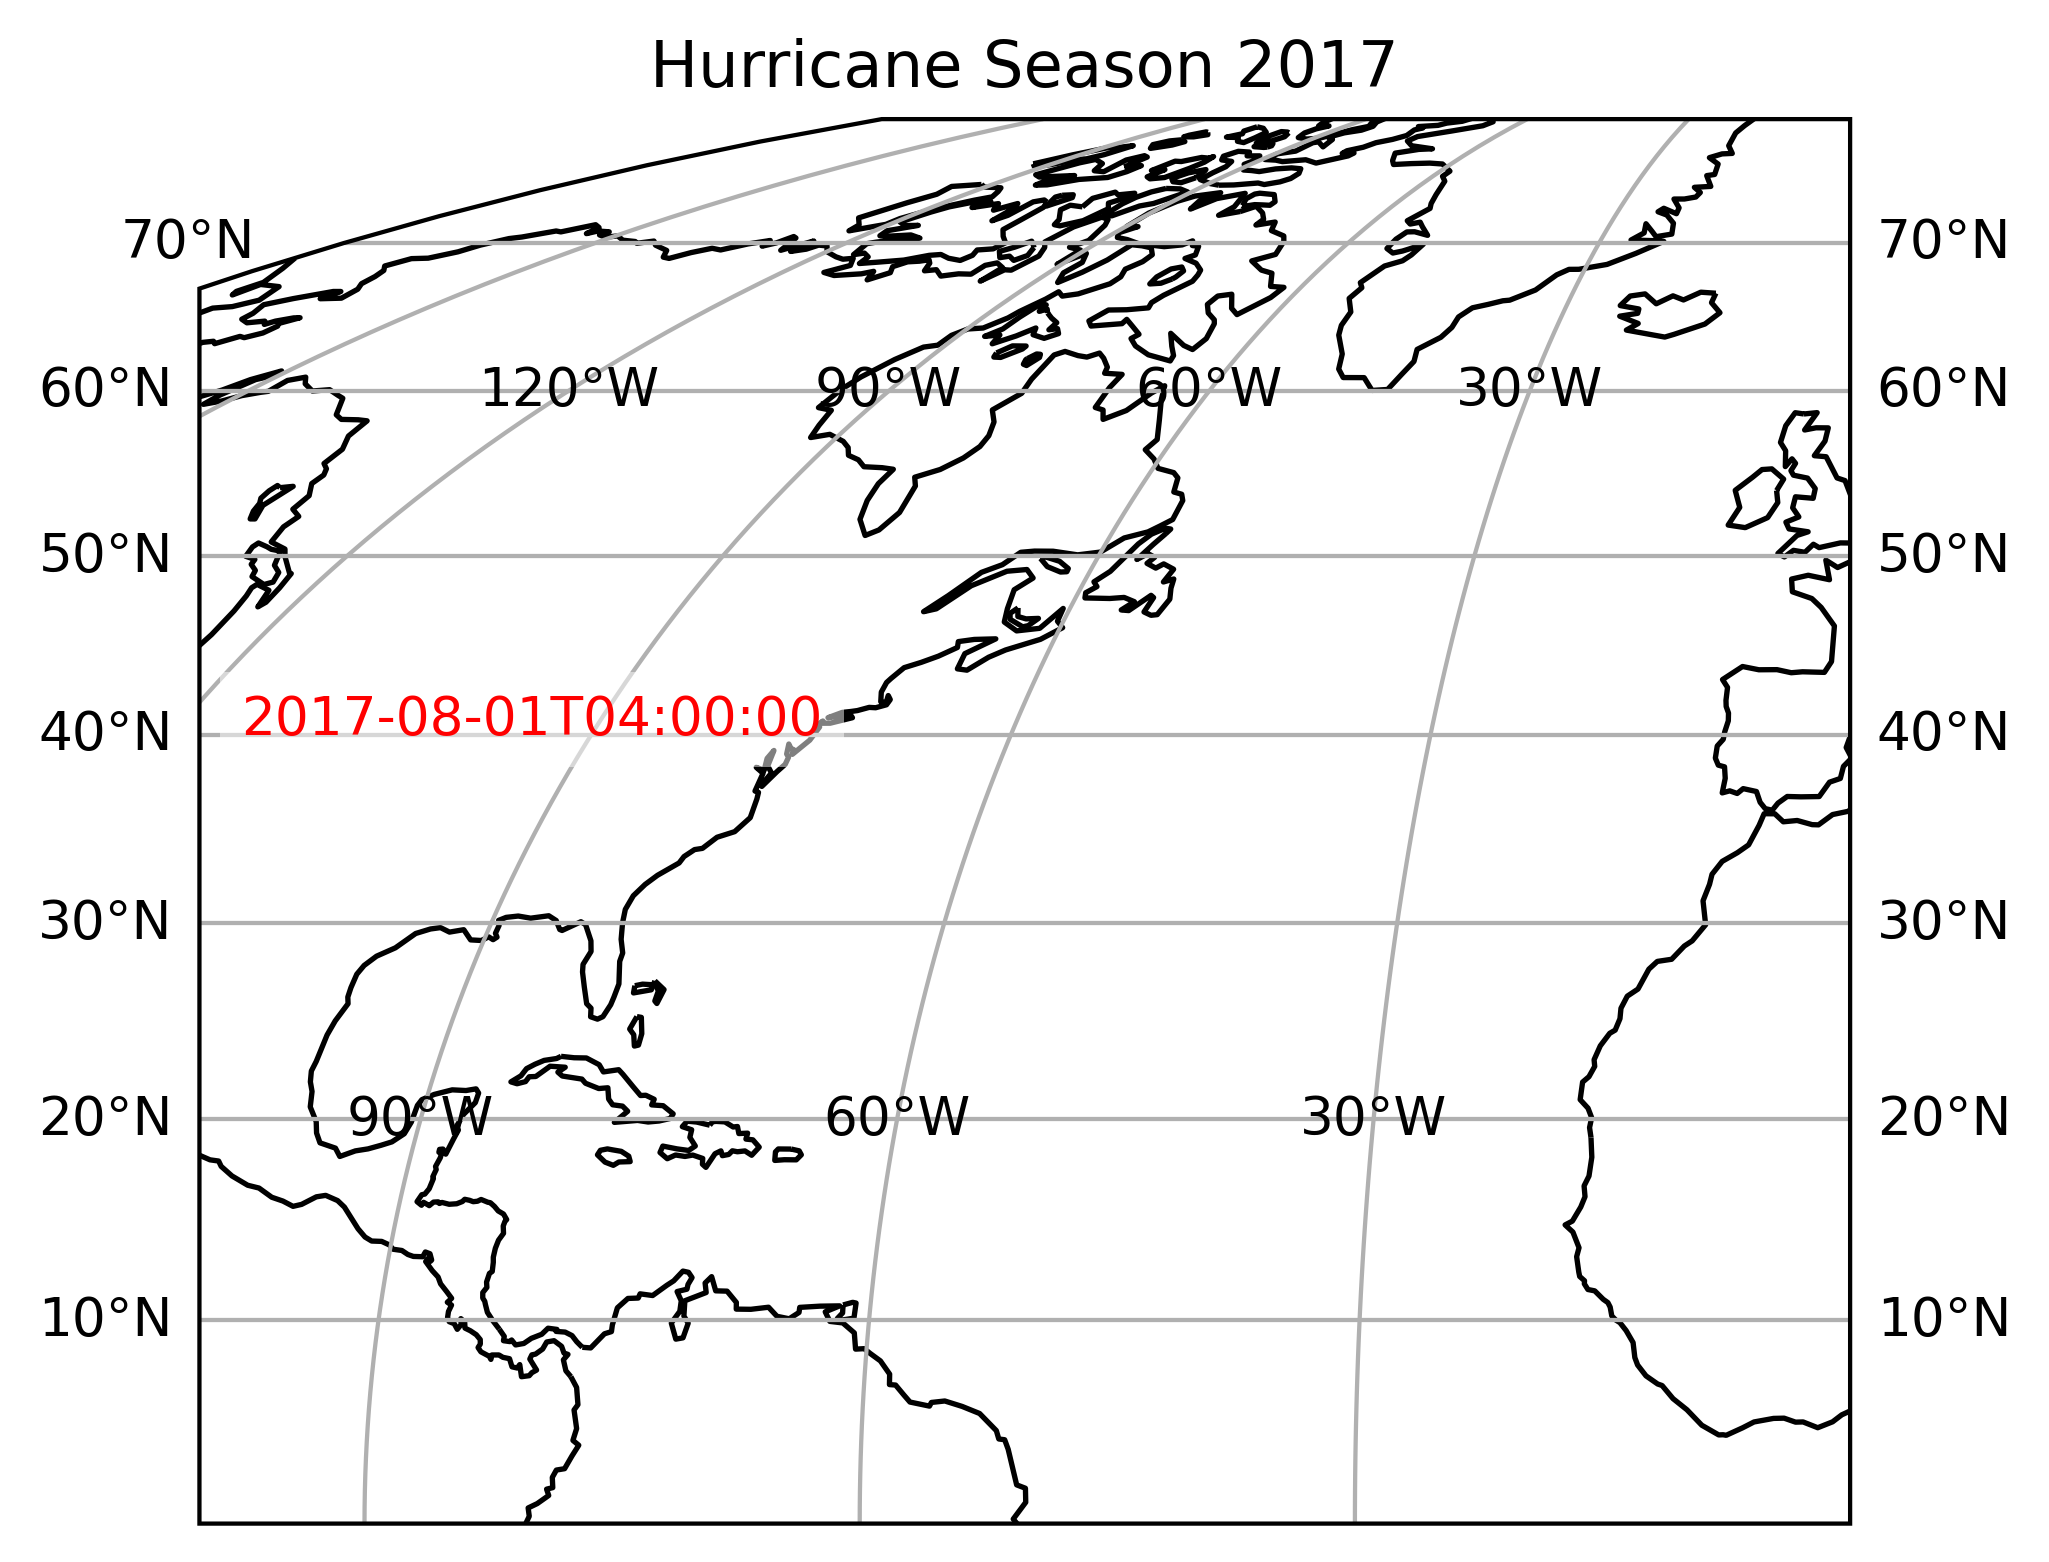

In [9]:
DPI = 384
fig = plt.figure(figsize=(7.75, 4.75), dpi=DPI)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
ax.coastlines()
ax.set_extent([-100, 0, 0, 80], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
datetime_label = ax.text(-115, 40, np.datetime_as_string(start_dt, "s"),
    fontsize=10, 
    color="red", 
    transform=ccrs.PlateCarree(), 
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
)
ax.set_title("Hurricane Season "+str(year))

To generate the animation we need to work on the data of each individual storm and each individual drifter. Because these datasets are organized as ragged arrays, we use the clouddrift `unpack` function to generate lists of data. The `unpack` function takes as arguments a ragged array input and a *rowsize* variable that indicates the size of each row of the ragged array.

In [10]:
from clouddrift.ragged import unpack

# unpack the lat and lon data for the storms
storm_lons = unpack(matching_storms.lon, matching_storms.rowsize)
storm_lats = unpack(matching_storms.lat, matching_storms.rowsize)

# unpack the lat, lon, and sst data for the drifters
drifter_lons = unpack(matching_drifters.lon, matching_drifters.rowsize)
drifter_lats = unpack(matching_drifters.lat, matching_drifters.rowsize)
drifter_temps = unpack(matching_drifters.temp, matching_drifters.rowsize)

Using the index of each individual trajectory (storm and drifter) we retrieve its associated data variable segment of the lon, lat and temp ragged array data variables.

Using these segments we create an initial plot of each trajectory. All plotted lines/trajectories are stored alongside their associated data variable segments.

This is so that we can update the line/trajectories in the animation we want to create.

In [11]:
storm_lines = list()
drifter_lines = list()


for storm_idx, _ in enumerate(matching_storms.id):
    selected_lon, selected_lat = storm_lons[storm_idx], storm_lats[storm_idx]
    selected_lon, selected_lat = selected_lon.set_xindex("time"), selected_lat.set_xindex("time")
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=3,
        transform=ccrs.PlateCarree(),
    )
    storm_lines.append((selected_lon, selected_lat, line[0]))

for drifter_idx, _ in enumerate(matching_drifters.id):
    selected_lon, selected_lat, selected_temp = drifter_lons[drifter_idx], drifter_lats[drifter_idx], drifter_temps[drifter_idx]
    selected_lon, selected_lat, selected_temp = (selected_lon.set_xindex("time"), selected_lat.set_xindex("time"), selected_temp.set_xindex("time"))
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=1,
        transform=ccrs.PlateCarree(),
    )
    drifter_lines.append((selected_lon, selected_lat, selected_temp, line[0]))

Let's now find the upper and lower bounds for the temperature values being plotted. We'll use this to create a colormap to color the drifter trajectories. 

In [12]:
import matplotlib.colors as colors

# find the min and max temperature for the colorscale/colormap
min_t = np.nanmin([np.nanmin(temp) for (_, _, temp, _) in drifter_lines])
max_t = np.nanmax([np.nanmax(temp) for (_, _, temp, _) in drifter_lines])

cmap = plt.get_cmap("inferno")
norm = colors.Normalize(vmin=min_t, vmax=max_t)

/tmp/ipykernel_101538/2933938511.py:4: RuntimeWarning: All-NaN axis encountered
  min_t = np.nanmin([np.nanmin(temp) for (_, _, temp, _) in drifter_lines])
/tmp/ipykernel_101538/2933938511.py:5: RuntimeWarning: All-NaN axis encountered
  max_t = np.nanmax([np.nanmax(temp) for (_, _, temp, _) in drifter_lines])


We can now add the legend for the colorbar:

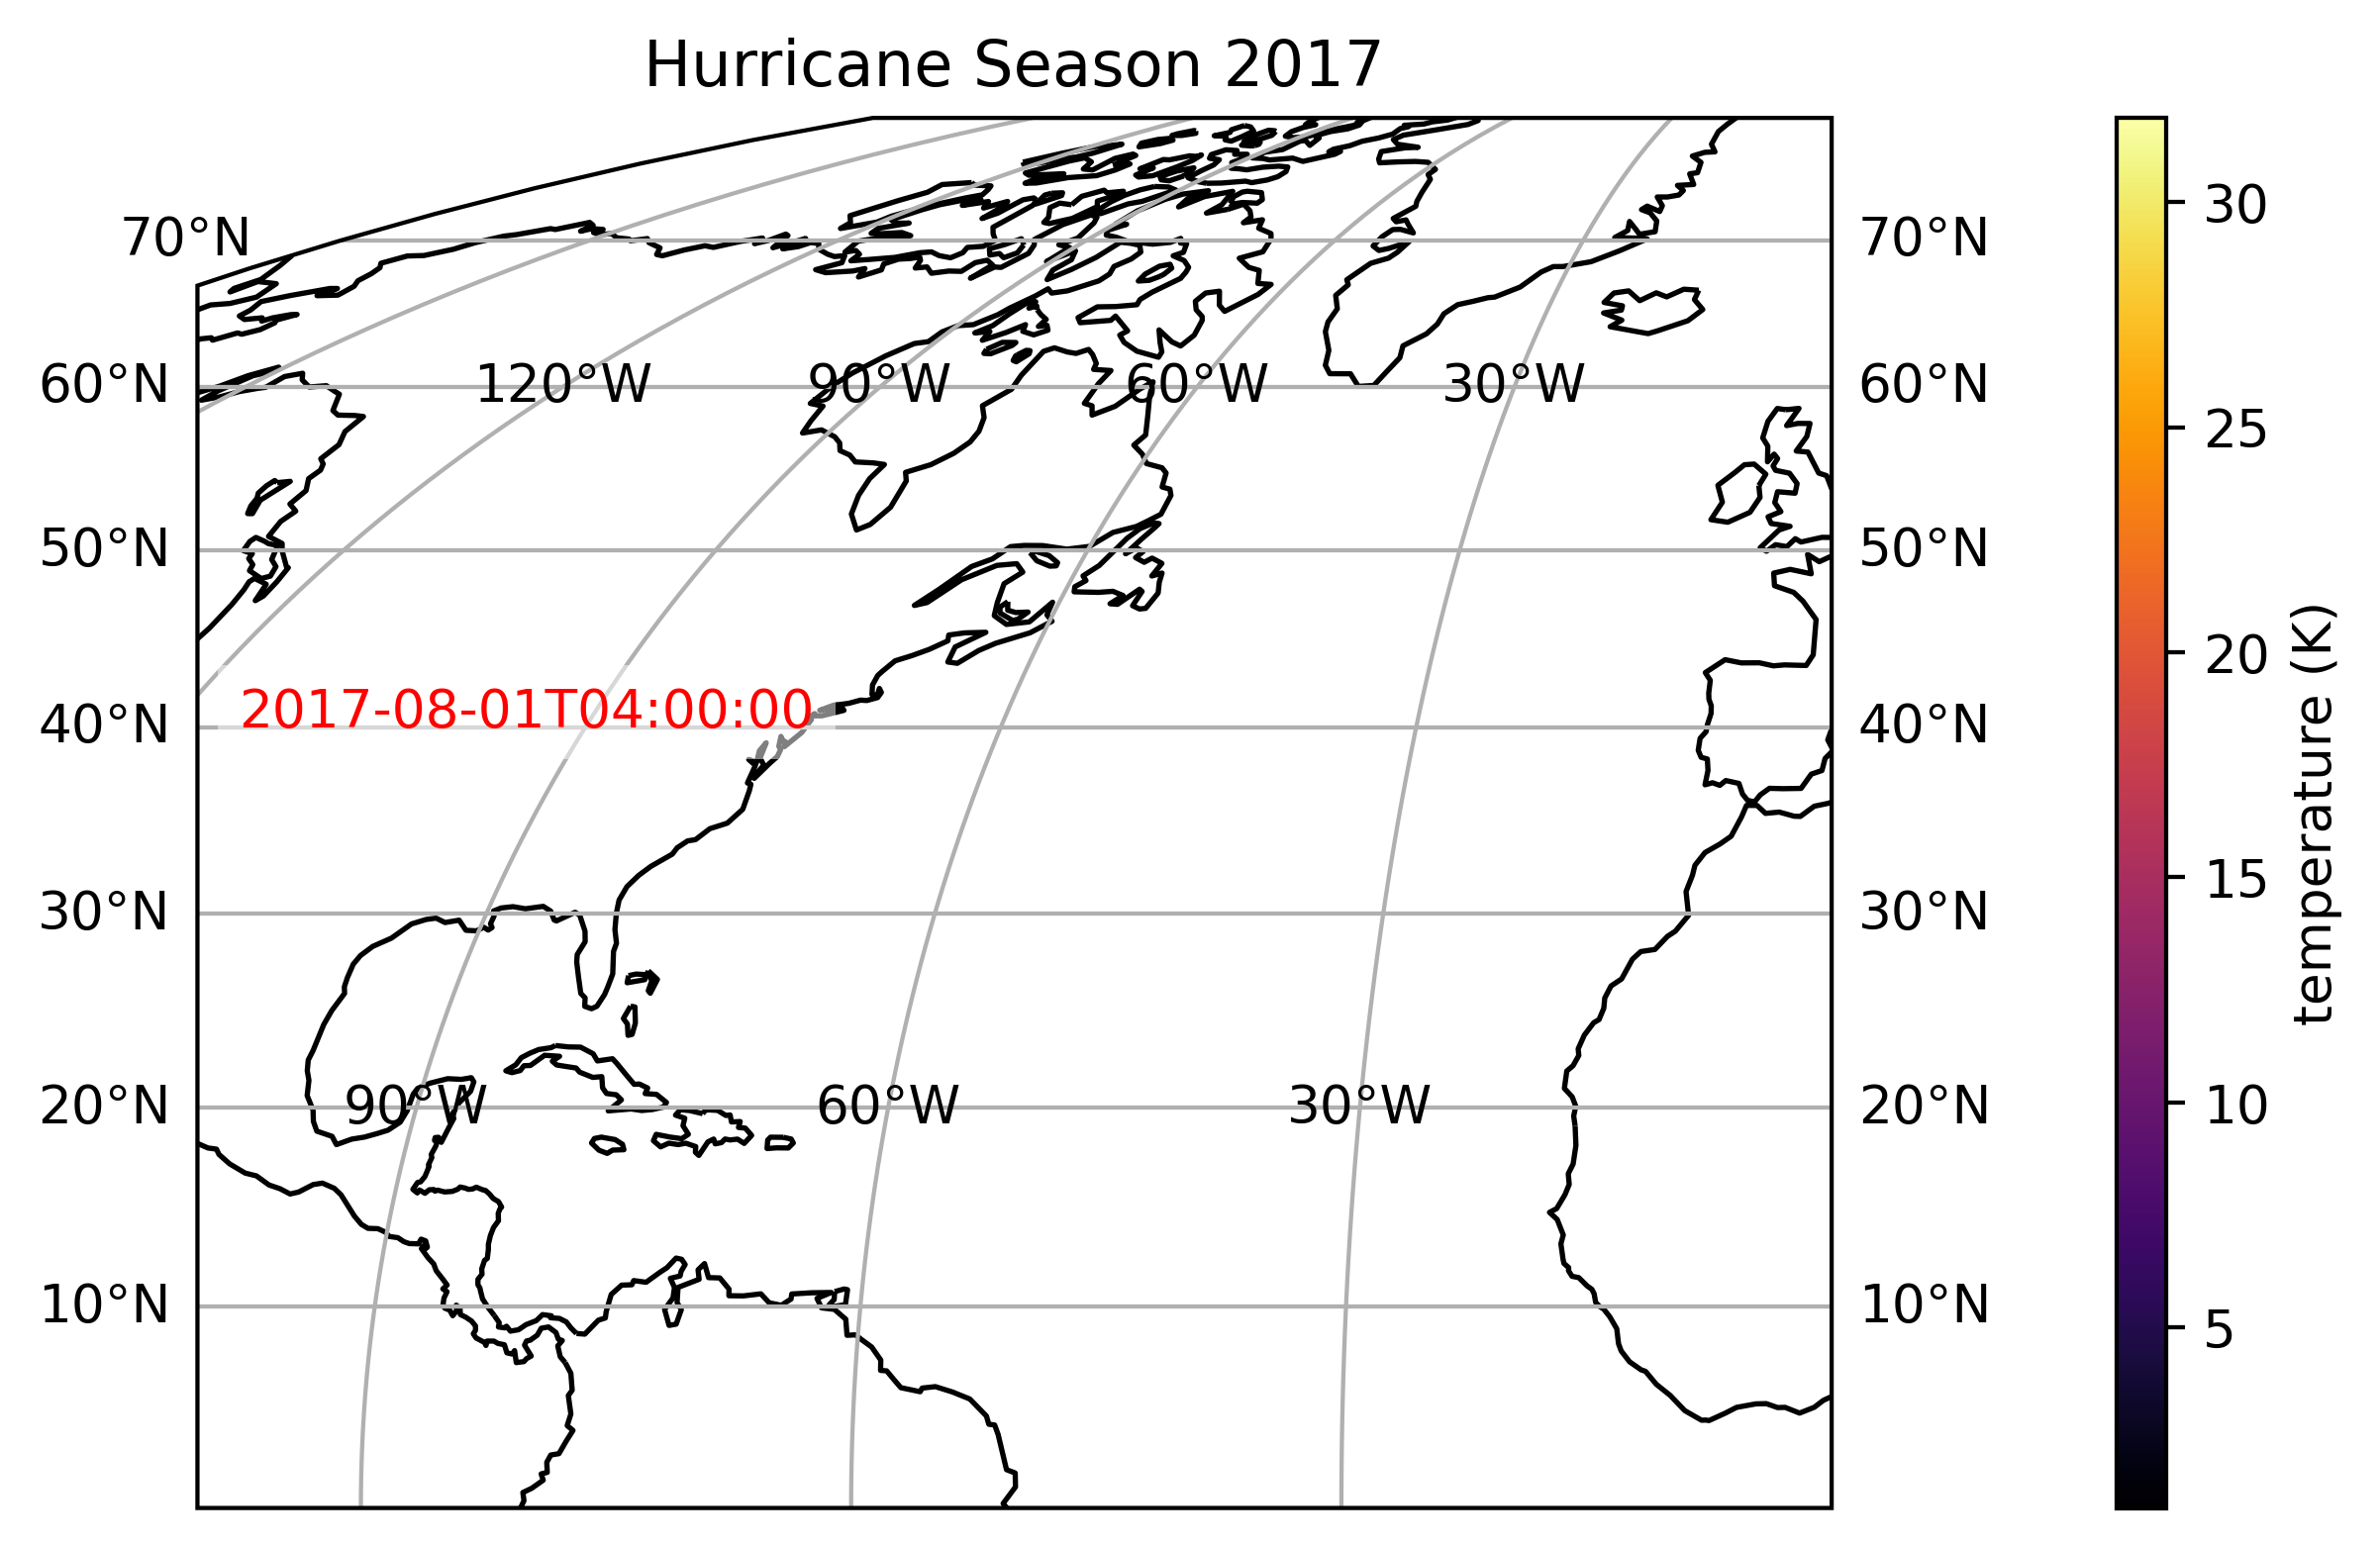

In [13]:
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.75, axes_class=plt.Axes)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label="temperature (℃)")
fig

### 3. Generate the Animation

To generate an animation we will need separate discrete frames each of which we associate with a datetime. 

Let's take the start and end datetime we've used for the `subset` criteria and generate an range of values that each map uniquely to the number of frames we want to generate.

In [14]:
frame_count = 500
daterange = np.arange(start_dt, end_dt, (end_dt - start_dt)/frame_count)
daterange[:10]

array(['2017-08-01T04:00:00', '2017-08-01T08:24:57',
       '2017-08-01T12:49:54', '2017-08-01T17:14:51',
       '2017-08-01T21:39:48', '2017-08-02T02:04:45',
       '2017-08-02T06:29:42', '2017-08-02T10:54:39',
       '2017-08-02T15:19:36', '2017-08-02T19:44:33'],
      dtype='datetime64[s]')

Lets now define the update function which will help us generate the animation. 

Since each individual frame has a datetime associated to it we leverage this as the end datetime when selecting the trajectories that will be plotted for the frame. We use the `start_dt` defined during the `subset` criteria definition as the start of the range we are selecting.

Using the storm and drifter plots we iterate through each of them and update their plotted lon and lat values. 

For the drifter trajectories we plot, we color them by taking the mean temperature of the last 4 observations (rough daily average). We also only plot a maximum of 20 observations.

In [15]:
import matplotlib.animation as animation

def update(frame_idx):
    tail_len = 20
    frame_dt = daterange[frame_idx]

    datetime_label.set_text(np.datetime_as_string(frame_dt, "s"))
    

    if (frame_idx == 0 or (frame_idx+1) % 100 == 0):
        print(f"generating index: {frame_idx}")

    updated_lines = list()
    for lon, lat, line in storm_lines:
        sel_lon = lon.sel(time=slice(start_dt, frame_dt))
        sel_lat = lat.sel(time=slice(start_dt, frame_dt))
        line.set_xdata(sel_lon)
        line.set_ydata(sel_lat)
        updated_lines.append(line)

    for lon, lat, temp, line, in drifter_lines:
        sel_lon = lon.sel(
            time=slice(start_dt, frame_dt)
        ).tail(obs=tail_len)
        sel_lat = lat.sel(
            time=slice(start_dt, frame_dt)
        ).tail(obs=tail_len)
        sel_temp = temp.sel(
            time=slice(start_dt, frame_dt)
        ).tail(obs=4)

        line.set_xdata(sel_lon)
        line.set_ydata(sel_lat)
        line.set_color(cmap(norm(np.nanmean(sel_temp))))

        updated_lines.append(line)
    return updated_lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=frame_count, interval=50)

Finally, let's generate the animation!

In [16]:
import warnings
warnings.filterwarnings("ignore") # bad practice and should never be used but helps us keep the output clean and should only ever be used in experimental/sample code.

ani.save("storm_drifters.gif", dpi=DPI)

generating index: 0
generating index: 0
generating index: 99
generating index: 199
generating index: 299
generating index: 399
generating index: 499


Your working directory should now contains the `storm_drifters.gif` file. Enjoy!